# Final charts


In [142]:
import numpy as np
import torch
from typing import Literal
import os
import json
from safetensors import safe_open
from safetensors.torch import load_file
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import wandb
import warnings
sys.path.append("../")
from jacobian_saes.utils import load_pretrained, run_sandwich


In [43]:
np.random.seed(42)
torch.manual_seed(42)

In [39]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


## Jacobian sparsity
Run `runners/histogram.py` first to get the data

We also plot the cumulative density function because it lets us see the differences more easily

In [15]:
model = "pythia-70m-deduped"
layer = 3

def get_hist_path(model: str, layer: int, trained_with_jac: bool = True):
    return f"../results/histograms/sae_pair_{model}_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0.safetensor"

with safe_open(get_hist_path(model, layer, True), framework="pt") as f:
    hist = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist_no_optim = load_file(get_hist_path(model, layer, False))["hist"]


In [16]:
upper_zoom_thresh = 0.1
cropped_bin_centers = bin_centers[bin_centers < upper_zoom_thresh]
cropped_hist = hist[bin_centers < upper_zoom_thresh]
cropped_hist_no_optim = hist_no_optim[bin_centers < upper_zoom_thresh]

cdf = hist.cumsum(dim=0) / hist.sum()
cdf_no_optim = hist_no_optim.cumsum(dim=0) / hist_no_optim.sum()


In [17]:
thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds = []
num_above_thresholds_no_optim = []
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    num_above_thresholds.append(hist[idx:].sum().item() / n_tokens_in_hist)
    num_above_thresholds_no_optim.append(hist_no_optim[idx:].sum().item() / n_tokens_in_hist)
num_above_thresholds, num_above_thresholds_no_optim

([233.8166784, 115.6935168, 72.3455168, 49.8944672],
 [854.8892672, 704.6360576, 581.183488, 482.4617984])

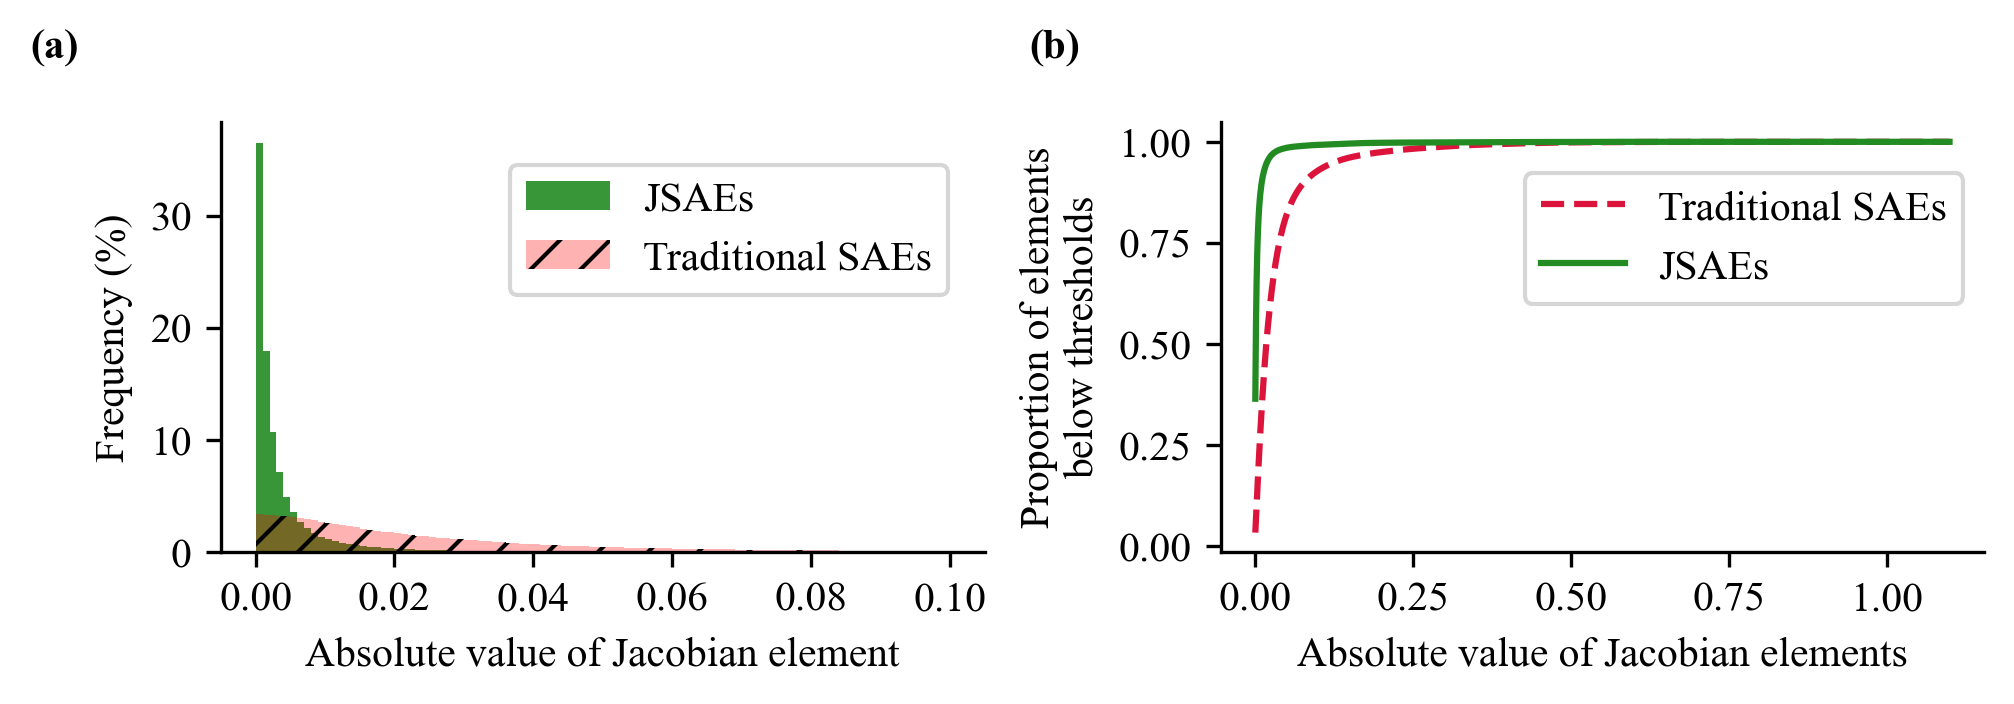

In [18]:
# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 2.5), dpi=300)

# First subplot (histogram)
width = (bin_edges[1] - bin_edges[0]).item()
ax1.bar(cropped_bin_centers.cpu().numpy(), 
       cropped_hist.cpu().numpy() / hist.sum().item() * 100,
       width=width,
       color='forestgreen',
       alpha=0.9,
       label='JSAEs')
ax1.bar(cropped_bin_centers.cpu().numpy(),
       cropped_hist_no_optim.cpu().numpy() / hist_no_optim.sum().item() * 100,
       width=width,
       color='red',
       alpha=0.3,
       hatch='//',
       label='Traditional SAEs')
ax1.set_xlabel('Absolute value of Jacobian element')
ax1.set_ylabel('Frequency (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95), fancybox=True)

# Second subplot (CDF)
ax2.plot(bin_centers.cpu().numpy(), 
       cdf_no_optim.cpu().numpy(),
       color='crimson',
       linestyle='--',
       label='Traditional SAEs')
ax2.plot(bin_centers.cpu().numpy(),
       cdf.cpu().numpy(),
       color='forestgreen',
       linestyle='-',
       label='JSAEs')
ax2.set_xlabel('Absolute value of Jacobian elements')
ax2.set_ylabel('Proportion of elements\nbelow thresholds')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.93), fancybox=True)

# Add subplot labels (a) and (b)
ax1.text(-0.25, 1.15, '(a)', transform=ax1.transAxes, fontsize=10, fontweight='bold')
ax2.text(-0.25, 1.15, '(b)', transform=ax2.transAxes, fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=1.0)

# Save the combined figure
plt.savefig('./charts/jac_hist.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

One figure for demonstrating sparsity with a bunch of different metrics (subcharts) incl this one

The Jacobian is generally smaller here

# Example Jacobian before and after

In [19]:
layer = 3

def get_wandb_path(layer: int, trained_with_jac: bool = True):
    return f"lucyfarnik/jsaes_pythia70m2/sae_pair_pythia-70m-deduped_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0"

sae_pair, model, mlp_with_grads, layer = load_pretrained(get_wandb_path(layer))
sae_pair_no_optim = load_pretrained(get_wandb_path(layer, False))[0]

/Users/tz20913/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Research/Jacobian SAEs/notebooks/../jacobian_saes/sae_pair.py:148: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Loaded pretrained model pythia-70m-deduped into HookedTransformer
Loaded pretrained model pythia-70m-deduped into HookedTransformer


In [20]:
_, cache = model.run_with_cache("Never gonna give you up", stop_at_layer=layer+1,
                                names_filter=[sae_pair.cfg.hook_name])
acts = cache[sae_pair.cfg.hook_name]
jacobian, _ = run_sandwich(sae_pair, mlp_with_grads, acts)
jacobian_no_optim, _ = run_sandwich(sae_pair_no_optim, mlp_with_grads, acts)

In [21]:
# Reshuffle (otherwise the ordering is determined by the size of the SAE latent activations which makes it look as if there's a correlation)
def shuffle_jacobian(jacobian):
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-1])]
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-2]), :]
    return jacobian

jacobian = shuffle_jacobian(jacobian)
jacobian_no_optim = shuffle_jacobian(jacobian_no_optim)

In [22]:
def add_jacobian_panel(fig, gs, jacobian, jacobian_no_optim, position='right', 
                      normalization: Literal[None, "L1", "L2"] = None,
                      width_ratio: float = 1.0):
    """Add Jacobian heatmap panel to a figure at specified GridSpec position."""
    idx = 1 if position == 'right' else 0
    
    # Process Jacobians and determine scale
    vmax = 0
    jacs = []
    jacs_no_optim = []
    for seq_pos in range(4):
        jac = jacobian[0, seq_pos+1].detach().cpu().abs().numpy()
        jac_no_optim = jacobian_no_optim[0, seq_pos+1].detach().cpu().abs().numpy()
        
        if normalization == "L1":
            jac /= np.abs(jac).sum()
            jac_no_optim /= np.abs(jac_no_optim).sum()
        elif normalization == "L2":
            jac /= np.sqrt(np.sum(jac**2))
            jac_no_optim /= np.sqrt(np.sum(jac_no_optim**2))
            
        vmax = max(vmax, max(jac.max(), jac_no_optim.max()))
        jacs.append(jac)
        jacs_no_optim.append(jac_no_optim)
    
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[idx], 
                                              wspace=0.15, hspace=0.15)
    
    axes = []
    for seq_pos, (jac, jac_no_optim) in enumerate(zip(jacs, jacs_no_optim)):
        ax_top = fig.add_subplot(inner_gs[0, seq_pos])
        ax_bottom = fig.add_subplot(inner_gs[1, seq_pos])
        axes.extend([ax_top, ax_bottom])
        
        im1 = ax_top.imshow(jac_no_optim, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        im2 = ax_bottom.imshow(jac, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        
        # Configure axes
        # ax_top.set_xticks([0, 10, 20, 30])
        ax_top.set_xticks([])
        ax_top.set_yticks([0, 10, 20, 30])
        if width_ratio == 2:
            ax_bottom.set_xticks([0, 10, 20, 30])
        else:
            ax_bottom.set_xticks([0, 12, 24])
        ax_bottom.set_yticks([0, 10, 20, 30])
        
        if seq_pos > 0:
            ax_top.set_yticks([])
            ax_bottom.set_yticks([])
        
        if seq_pos == 0:
            ax_top.set_ylabel('Traditional SAE')
            ax_bottom.set_ylabel('JSAE')
        
        if seq_pos == 3:
            if position == "right":
                cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            else:
                if width_ratio == 2:
                    cbar_ax = fig.add_axes([0.53, 0.15, 0.02, 0.7])
                else:    
                    cbar_ax = fig.add_axes([0.44, 0.15, 0.02, 0.7])
            plt.colorbar(im1, cax=cbar_ax)
        
        ax_bottom.set_xlabel(f'Token {seq_pos+1}')
        ax_top.tick_params(axis='both', which='major')
        ax_bottom.tick_params(axis='both', which='major')
    
    return axes

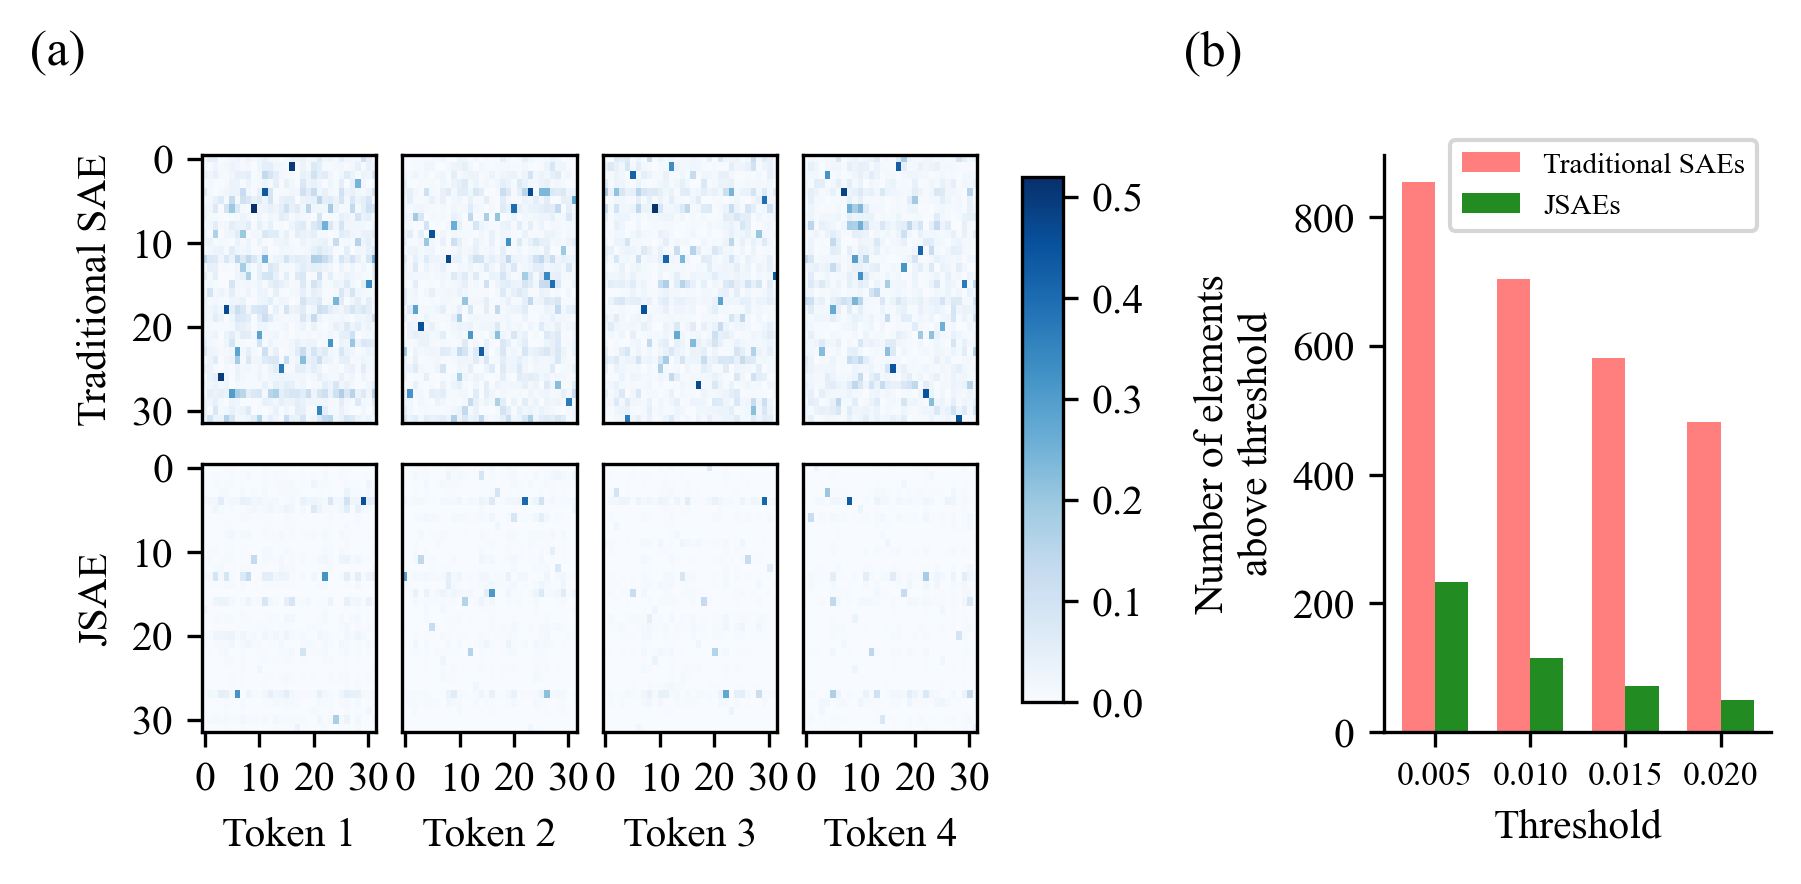

In [62]:
# Figure 1: Example Jacobians + Bar plot
fig1 = plt.figure(figsize=(6.75, 2.5), dpi=300)

gs1 = plt.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.7)

# Left panel: Jacobian examples with no normalization
add_jacobian_panel(fig1, gs1, jacobian, jacobian_no_optim, position='left',
                   normalization=None, width_ratio=2)

# Right panel: Bar plot
ax1 = fig1.add_subplot(gs1[1])
bar_width = 0.35
bar_positions = np.arange(len(thresholds))
ax1.bar(bar_positions, num_above_thresholds_no_optim, bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
ax1.bar(bar_positions + bar_width, num_above_thresholds, bar_width, 
        label='JSAEs', color='forestgreen')
ax1.set_xticks(bar_positions + bar_width / 2)
ax1.set_xticklabels([f"{t:.3f}" for t in thresholds], fontsize=8)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of elements\nabove threshold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.05), fancybox=True, fontsize=7)

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.61, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_sparsity.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


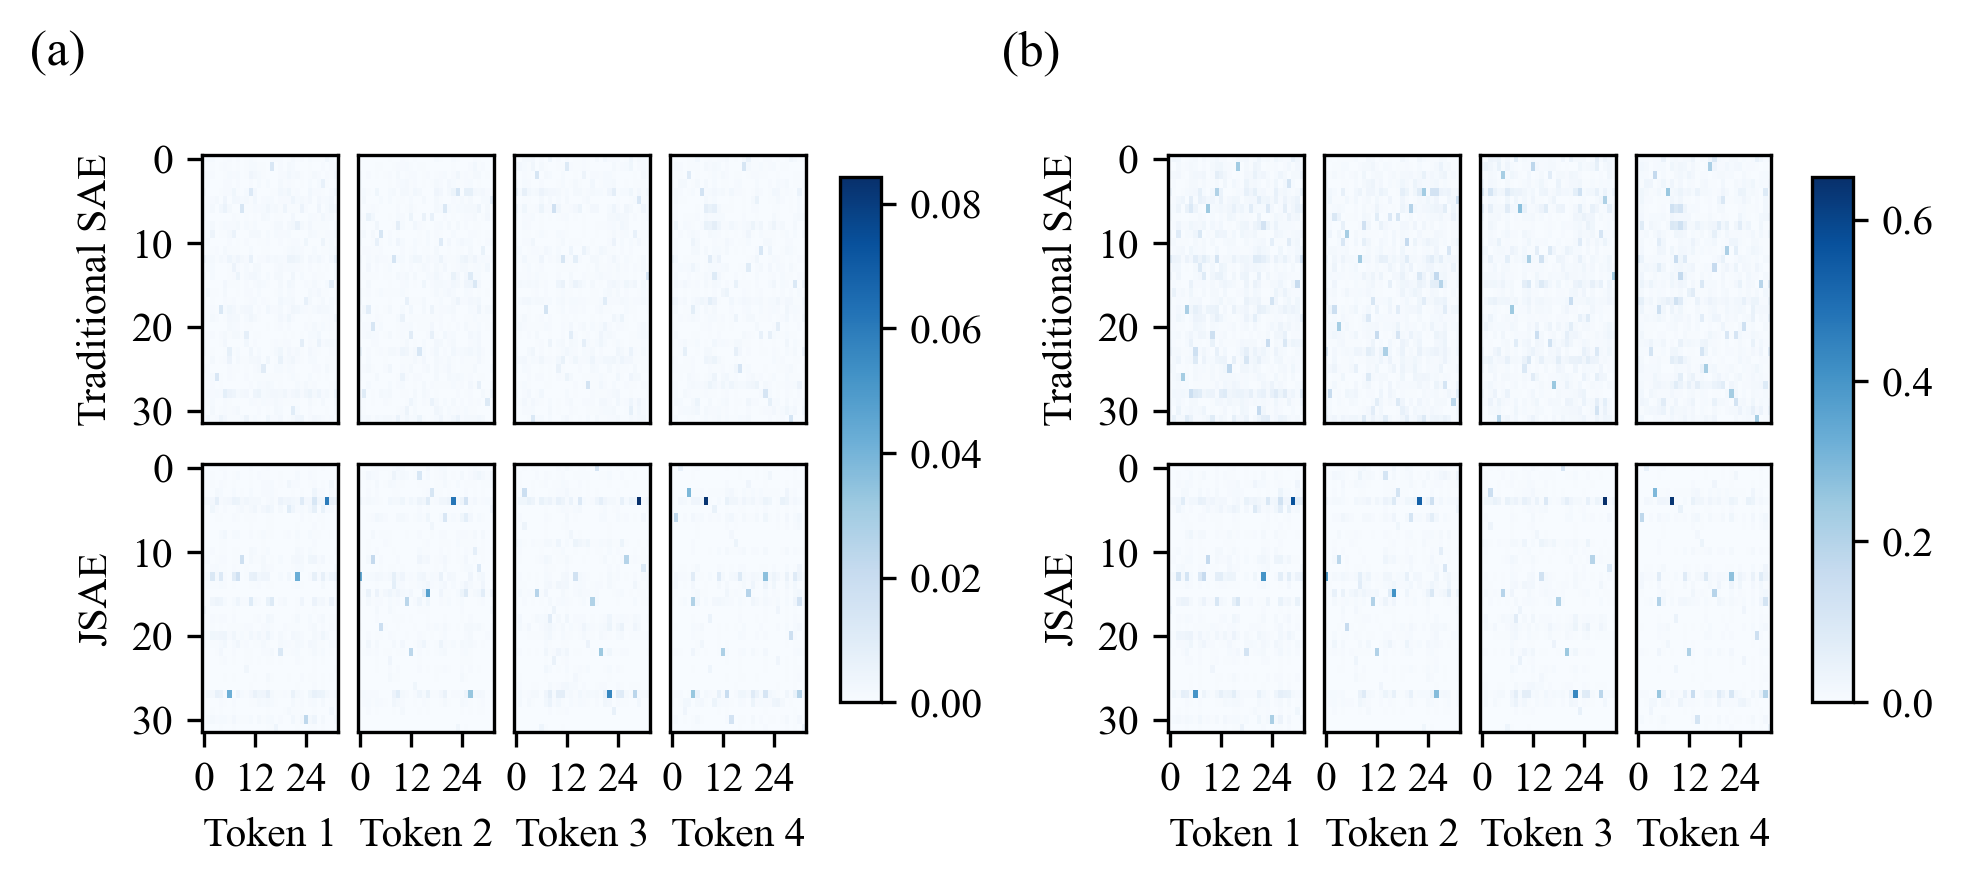

In [34]:
fig2 = plt.figure(figsize=(6.75, 2.5), dpi=300)
gs2 = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.6)

# Left panel: L1 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='left', normalization="L1")

# Right panel: L2 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='right', normalization="L2")

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.52, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_examples_normed.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Random LLMs

In [37]:
model = "pythia-70m-deduped"
layer = 3

def get_randomized_hist_path(model: str, layer: int, trained_with_jac: bool, randomized: bool):
    path = f"../results/histograms/sae_pair_{model}"
    if randomized:
        path += "-randomized"
    path += f"_layer{layer}_16384_J{1 if trained_with_jac else 0}_k32:v0.safetensor"
    return path

histograms = {}
with safe_open(get_randomized_hist_path(model, layer, True, False), framework="pt") as f:
    histograms["J1"] = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
histograms["J1-randomized"] = load_file(get_randomized_hist_path(model, layer, True, True))["hist"]
histograms["J0"] = load_file(get_randomized_hist_path(model, layer, False, False))["hist"]
histograms["J0-randomized"] = load_file(get_randomized_hist_path(model, layer, False, True))["hist"]

thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds_in_hists = {key: [] for key in histograms.keys()}
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    for key, hist in histograms.items():
        num_above_thresholds_in_hists[key].append(hist[idx:].sum().item() / n_tokens_in_hist)


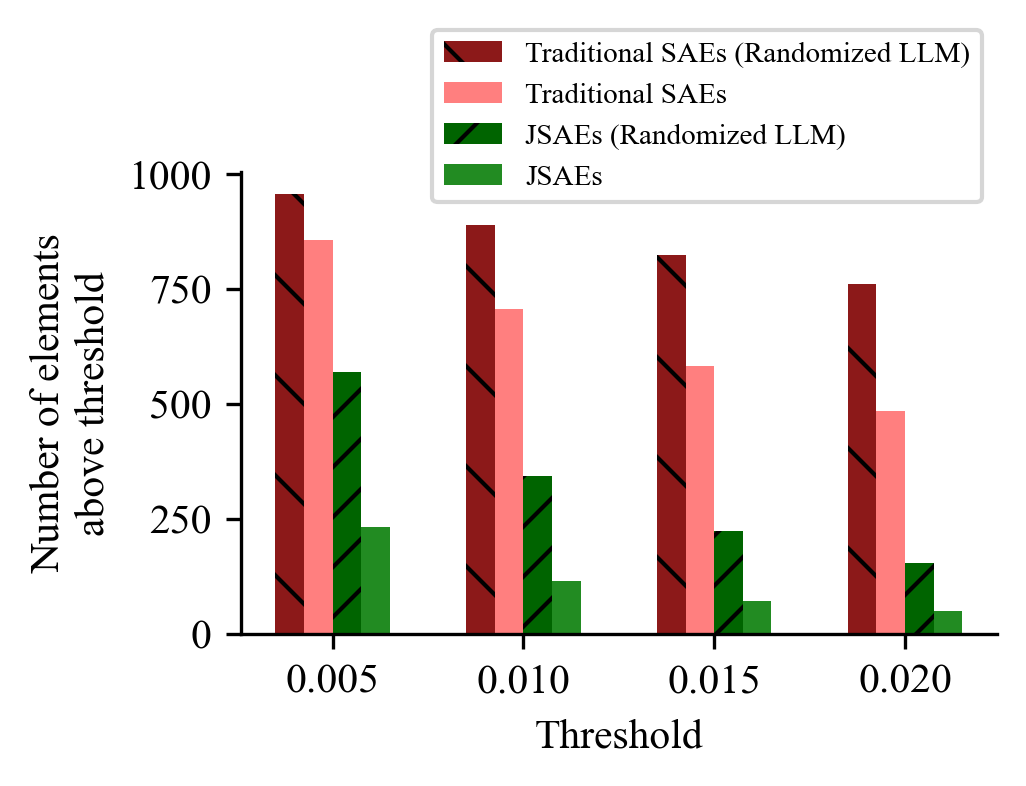

In [81]:
fig = plt.figure(figsize=(3.25, 2), dpi=300)

# Bar plot with 4 bars
bar_width = 0.15
bar_positions = np.arange(len(thresholds))

plt.bar(bar_positions - bar_width, num_above_thresholds_in_hists['J0-randomized'], bar_width, 
        label='Traditional SAEs (Randomized LLM)', color='maroon', alpha=0.9, hatch='\\')
plt.bar(bar_positions, num_above_thresholds_in_hists['J0'], bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
plt.bar(bar_positions + bar_width, num_above_thresholds_in_hists['J1-randomized'], bar_width, 
        label='JSAEs (Randomized LLM)', color='darkgreen', hatch='//')
plt.bar(bar_positions + 2*bar_width, num_above_thresholds_in_hists['J1'], bar_width, 
        label='JSAEs', color='forestgreen')

# Adjust x-axis to center the labels between all 4 bars
plt.xticks(bar_positions + bar_width/2, [f"{t:.3f}" for t in thresholds])
plt.xlabel('Threshold')
plt.ylabel('Number of elements\nabove threshold')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.34), fancybox=True, fontsize=7)
plt.savefig('./charts/randomized.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Sweeps

## Jacobian sweep

### CE loss score vs jac elements above 0.01

/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_52013/2464323874.py:5: UserWarning: You're not fetching all of the runs.


  warnings.warn("You're not fetching all of the runs.\n\n")


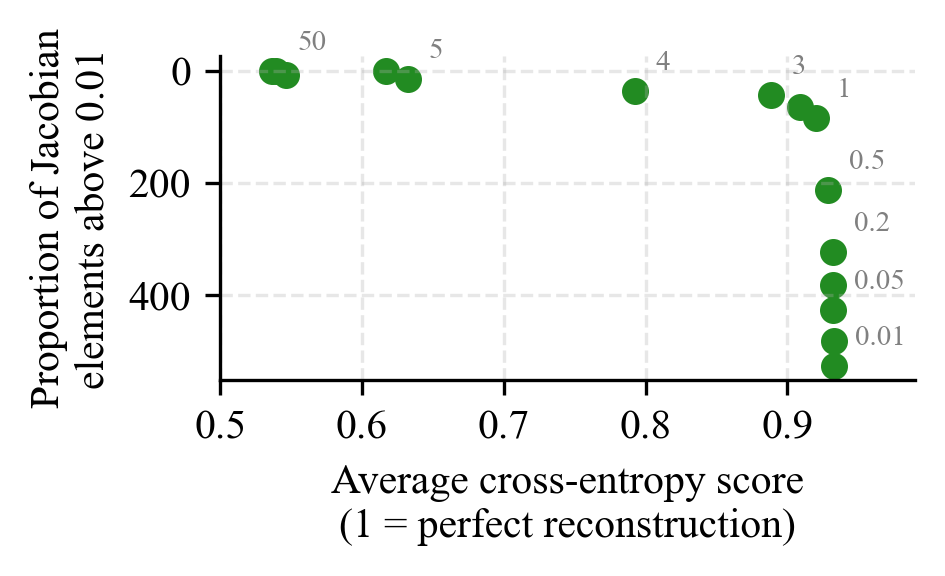

In [42]:
api = wandb.Api()
runs = api.runs("lucyfarnik/pythia70m-l3-sweep-j")

if runs.more:
    warnings.warn("You're not fetching all of the runs.\n\n")

metrics = ["jacobian_sparsity/jac_abs_above_0.01",
           "model_performance_preservation/ce_loss_score",
           "model_performance_preservation/ce_loss_score2"]

data = []
for run in runs:
    if run.state != "finished":
        warnings.warn(f"Run {run.id} is not finished.")
        continue
    run_data = {
        "jacobian_coefficient": run.config["jacobian_coefficient"],
    }
    for m in metrics:
        run_data[m.split("/")[-1]] = run.summary[m]
    data.append(run_data)

df = pd.DataFrame(data)
df["avd_ce_loss_score"] = (df["ce_loss_score"] + df["ce_loss_score2"]) / 2
# df["jac_coeff_with_label"] = df["jacobian_coefficient"].apply(lambda x: f"λ={x}")

plt.figure(figsize=(3.25, 2), dpi=300)

# Create scatter plot
plt.scatter(
    df["avd_ce_loss_score"],
    df["jac_abs_above_0.01"],
    color='forestgreen',
    s=30  # Marker size
)

# Add text annotations for specific values
annotate_values = [0.01, 0.05, 0.2, 0.5, 1, 3, 4, 5, 50]
for _, row in df.iterrows():
    if row["jacobian_coefficient"] in annotate_values:
        jac_coef = row["jacobian_coefficient"]
        if jac_coef == int(jac_coef):
            jac_coef = int(jac_coef)

        plt.annotate(
            f'{jac_coef}',
            (row["avd_ce_loss_score"], row["jac_abs_above_0.01"]),
            xytext=(5, 5),  # Offset
            textcoords='offset points',
            fontsize=7,
            color='gray'
        )

# Customize axes
plt.xlim(0.5, 0.99)
plt.gca().invert_yaxis()  # Reverse y-axis

# Labels
plt.xlabel('Average cross-entropy score\n(1 = perfect reconstruction)', multialignment='center')
plt.ylabel('Proportion of Jacobian\nelements above 0.01', multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/tradeoff_reconst_jac.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


TODO rewrite to instead get the data from the eval runner

TODO do a bunch of these for different metrics; the more charts per unit of effort the better

TODO big grid of charts where the charts in a given row always have the same y axis and plots in the same col always have the same x axis
- These should include L1 sparsity dividied by sqrt(L2) — if those don't look as good, we might need to train with that as the objective to demonstrate that we're not just making the Jacs smaller

# $f_s$ is mostly linear
The numbers in this plot are generated by code in the `fs_approx_linear` notebook

In [44]:
take_abs = True
n_downsampled = 1_000

abl_data = load_file("../results/ablation/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0.safetensor")
abl_samples_full = abl_data["results"]

is_on_line = (abl_samples_full[:, 0] + abl_samples_full[:, 1]).abs() < 0.1

if take_abs:
    abl_samples_full.abs_()
    # abl_samples_no_optim.abs_()


abl_sample_small = abl_samples_full[torch.randint(0, abl_samples_full.shape[0], (n_downsampled,))]


In [75]:
# Comes from `fs_approx_linear.ipynb`, copy-pasted cause aaaa icml deadline
func_xs = np.array([0.        , 0.005005  , 0.01001001, 0.01501501, 0.02002002, 0.02502503, 0.03003003, 0.03503503, 0.04004004, 0.04504504, 0.05005005, 0.05505505, 0.06006006, 0.06506506, 0.07007007, 0.07507508, 0.08008008, 0.08508508, 0.09009009, 0.09509509, 0.1001001 , 0.1051051 , 0.1101101 , 0.11511511, 0.12012012, 0.12512513, 0.13013013, 0.13513513, 0.14014013, 0.14514513, 0.15015015, 0.15515515, 0.16016015, 0.16516516, 0.17017016, 0.17517518, 0.18018018, 0.18518518, 0.19019018, 0.19519518, 0.2002002 , 0.2052052 , 0.2102102 , 0.2152152 , 0.22022021, 0.22522521, 0.23023023, 0.23523523, 0.24024023, 0.24524523, 0.25025025, 0.25525525, 0.26026025, 0.26526526, 0.27027026, 0.27527526, 0.28028026, 0.28528526, 0.29029027, 0.2952953 , 0.3003003 , 0.3053053 , 0.3103103 , 0.3153153 , 0.3203203 , 0.3253253 , 0.3303303 , 0.3353353 , 0.34034032, 0.34534532, 0.35035035, 0.35535535, 0.36036035, 0.36536536, 0.37037036, 0.37537536, 0.38038036, 0.38538536, 0.39039037, 0.39539537, 0.4004004 , 0.4054054 , 0.4104104 , 0.4154154 , 0.4204204 , 0.4254254 , 0.4304304 , 0.4354354 , 0.44044042, 0.44544542, 0.45045042, 0.45545545, 0.46046045, 0.46546546, 0.47047046, 0.47547546, 0.48048046, 0.48548546, 0.49049047, 0.49549547, 0.5005005 , 0.5055055 , 0.5105105 , 0.5155155 , 0.5205205 , 0.5255255 , 0.5305305 , 0.5355355 , 0.5405405 , 0.5455455 , 0.5505505 , 0.5555555 , 0.5605605 , 0.5655655 , 0.5705705 , 0.57557553, 0.58058053, 0.58558553, 0.5905906 , 0.5955956 , 0.6006006 , 0.6056056 , 0.6106106 , 0.6156156 , 0.6206206 , 0.6256256 , 0.6306306 , 0.6356356 , 0.6406406 , 0.6456456 , 0.6506506 , 0.6556556 , 0.6606606 , 0.6656656 , 0.6706706 , 0.67567563, 0.68068063, 0.68568563, 0.69069064, 0.6956957 , 0.7007007 , 0.7057057 , 0.7107107 , 0.7157157 , 0.7207207 , 0.7257257 , 0.7307307 , 0.7357357 , 0.7407407 , 0.7457457 , 0.7507507 , 0.7557557 , 0.7607607 , 0.7657657 , 0.7707707 , 0.77577573, 0.78078073, 0.78578573, 0.79079074, 0.79579574, 0.8008008 , 0.8058058 , 0.8108108 , 0.8158158 , 0.8208208 , 0.8258258 , 0.8308308 , 0.8358358 , 0.8408408 , 0.8458458 , 0.8508508 , 0.8558558 , 0.8608608 , 0.8658658 , 0.8708708 , 0.87587583, 0.88088083, 0.88588583, 0.89089084, 0.89589584, 0.90090084, 0.90590584, 0.9109109 , 0.9159159 , 0.9209209 , 0.9259259 , 0.9309309 , 0.9359359 , 0.9409409 , 0.9459459 , 0.9509509 , 0.9559559 , 0.9609609 , 0.9659659 , 0.9709709 , 0.97597593, 0.98098093, 0.98598593, 0.99099094, 0.99599594, 1.001001  , 1.006006  , 1.011011  , 1.016016  , 1.021021  , 1.026026  , 1.031031  , 1.036036  , 1.041041  , 1.046046  , 1.051051  , 1.056056  , 1.061061  , 1.066066  , 1.071071  , 1.076076  , 1.081081  , 1.086086  , 1.091091  , 1.096096  , 1.101101  , 1.106106  , 1.111111  , 1.116116  , 1.121121  , 1.126126  , 1.131131  , 1.136136  , 1.141141  , 1.146146  , 1.1511511 , 1.1561561 , 1.1611611 , 1.1661661 , 1.1711711 , 1.1761762 , 1.1811812 , 1.1861862 , 1.1911912 , 1.1961962 , 1.2012012 , 1.2062062 , 1.2112112 , 1.2162162 , 1.2212212 , 1.2262262 , 1.2312312 , 1.2362362 , 1.2412412 , 1.2462462 , 1.2512512 , 1.2562562 , 1.2612612 , 1.2662662 , 1.2712712 , 1.2762762 , 1.2812812 , 1.2862862 , 1.2912912 , 1.2962962 , 1.3013012 , 1.3063062 , 1.3113112 , 1.3163162 , 1.3213212 , 1.3263263 , 1.3313313 , 1.3363363 , 1.3413413 , 1.3463463 , 1.3513513 , 1.3563563 , 1.3613613 , 1.3663663 , 1.3713713 , 1.3763763 , 1.3813813 , 1.3863863 , 1.3913914 , 1.3963964 , 1.4014014 , 1.4064064 , 1.4114114 , 1.4164164 , 1.4214214 , 1.4264264 , 1.4314314 , 1.4364364 , 1.4414414 , 1.4464464 , 1.4514514 , 1.4564564 , 1.4614614 , 1.4664664 , 1.4714714 , 1.4764764 , 1.4814814 , 1.4864864 , 1.4914914 , 1.4964964 , 1.5015014 , 1.5065064 , 1.5115114 , 1.5165164 , 1.5215214 , 1.5265265 , 1.5315315 , 1.5365365 , 1.5415415 , 1.5465465 , 1.5515515 , 1.5565565 , 1.5615615 , 1.5665665 , 1.5715715 , 1.5765765 , 1.5815815 , 1.5865865 , 1.5915915 , 1.5965965 , 1.6016016 , 1.6066066 , 1.6116116 , 1.6166166 , 1.6216216 , 1.6266266 , 1.6316316 , 1.6366366 , 1.6416416 , 1.6466466 , 1.6516516 , 1.6566566 , 1.6616616 , 1.6666666 , 1.6716716 , 1.6766766 , 1.6816816 , 1.6866866 , 1.6916916 , 1.6966966 , 1.7017016 , 1.7067066 , 1.7117116 , 1.7167166 , 1.7217216 , 1.7267267 , 1.7317317 , 1.7367367 , 1.7417417 , 1.7467467 , 1.7517517 , 1.7567567 , 1.7617617 , 1.7667667 , 1.7717717 , 1.7767767 , 1.7817817 , 1.7867867 , 1.7917917 , 1.7967967 , 1.8018017 , 1.8068067 , 1.8118117 , 1.8168168 , 1.8218218 , 1.8268268 , 1.8318318 , 1.8368368 , 1.8418418 , 1.8468468 , 1.8518518 , 1.8568568 , 1.8618618 , 1.8668668 , 1.8718718 , 1.8768768 , 1.8818818 , 1.8868868 , 1.8918918 , 1.8968968 , 1.9019018 , 1.9069068 , 1.9119118 , 1.9169168 , 1.9219218 , 1.9269269 , 1.9319319 , 1.9369369 , 1.9419419 , 1.9469469 , 1.9519519 , 1.9569569 , 1.9619619 , 1.9669669 , 1.9719719 , 1.9769769 , 1.9819819 , 1.9869869 , 1.9919919 , 1.9969969 , 2.002002  , 2.007007  , 2.012012  , 2.017017  , 2.022022  , 2.027027  , 2.032032  , 2.037037  , 2.042042  , 2.047047  , 2.052052  , 2.057057  , 2.062062  , 2.067067  , 2.072072  , 2.077077  , 2.082082  , 2.087087  , 2.092092  , 2.097097  , 2.102102  , 2.107107  , 2.112112  , 2.117117  , 2.122122  , 2.127127  , 2.132132  , 2.1371372 , 2.142142  , 2.1471472 , 2.152152  , 2.1571572 , 2.162162  , 2.1671672 , 2.172172  , 2.1771772 , 2.182182  , 2.1871872 , 2.192192  , 2.1971972 , 2.202202  , 2.2072072 , 2.212212  , 2.2172172 , 2.222222  , 2.2272272 , 2.232232  , 2.2372372 , 2.242242  , 2.2472472 , 2.252252  , 2.2572572 , 2.262262  , 2.2672672 , 2.272272  , 2.2772772 , 2.282282  , 2.2872872 , 2.292292  , 2.2972972 , 2.3023021 , 2.3073072 , 2.3123121 , 2.3173172 , 2.3223221 , 2.3273273 , 2.3323321 , 2.3373373 , 2.3423421 , 2.3473473 , 2.3523524 , 2.3573573 , 2.3623624 , 2.3673673 , 2.3723724 , 2.3773773 , 2.3823824 , 2.3873873 , 2.3923924 , 2.3973973 , 2.4024024 , 2.4074073 , 2.4124124 , 2.4174173 , 2.4224224 , 2.4274273 , 2.4324324 , 2.4374373 , 2.4424424 , 2.4474473 , 2.4524524 , 2.4574573 , 2.4624624 , 2.4674673 , 2.4724724 , 2.4774773 , 2.4824824 , 2.4874873 , 2.4924924 , 2.4974973 , 2.5025024 , 2.5075073 , 2.5125124 , 2.5175173 , 2.5225224 , 2.5275273 , 2.5325325 , 2.5375373 , 2.5425425 , 2.5475473 , 2.5525525 , 2.5575573 , 2.5625625 , 2.5675676 , 2.5725725 , 2.5775776 , 2.5825825 , 2.5875876 , 2.5925925 , 2.5975976 , 2.6026025 , 2.6076076 , 2.6126125 , 2.6176176 , 2.6226225 , 2.6276276 , 2.6326325 , 2.6376376 , 2.6426425 , 2.6476476 , 2.6526525 , 2.6576576 , 2.6626625 , 2.6676676 , 2.6726725 , 2.6776776 , 2.6826825 , 2.6876876 , 2.6926925 , 2.6976976 , 2.7027025 , 2.7077076 , 2.7127125 , 2.7177176 , 2.7227225 , 2.7277277 , 2.7327325 , 2.7377377 , 2.7427425 , 2.7477477 , 2.7527525 , 2.7577577 , 2.7627625 , 2.7677677 , 2.7727726 , 2.7777777 , 2.7827828 , 2.7877877 , 2.7927928 , 2.7977977 , 2.8028028 , 2.8078077 , 2.8128128 , 2.8178177 , 2.8228228 , 2.8278277 , 2.8328328 , 2.8378377 , 2.8428428 , 2.8478477 , 2.8528528 , 2.8578577 , 2.8628628 , 2.8678677 , 2.8728728 , 2.8778777 , 2.8828828 , 2.8878877 , 2.8928928 , 2.8978977 , 2.9029028 , 2.9079077 , 2.9129128 , 2.9179177 , 2.9229228 , 2.9279277 , 2.9329329 , 2.9379377 , 2.9429429 , 2.9479477 , 2.9529529 , 2.9579577 , 2.9629629 , 2.9679677 , 2.9729729 , 2.9779778 , 2.9829829 , 2.9879878 , 2.9929929 , 2.997998  , 3.003003  , 3.008008  , 3.013013  , 3.018018  , 3.023023  , 3.028028  , 3.033033  , 3.038038  , 3.043043  , 3.048048  , 3.053053  , 3.058058  , 3.063063  , 3.068068  , 3.073073  , 3.078078  , 3.083083  , 3.088088  , 3.093093  , 3.098098  , 3.103103  , 3.108108  , 3.113113  , 3.118118  , 3.123123  , 3.128128  , 3.133133  , 3.138138  , 3.143143  , 3.148148  , 3.153153  , 3.158158  , 3.163163  , 3.168168  , 3.173173  , 3.178178  , 3.183183  , 3.188188  , 3.193193  , 3.198198  , 3.2032032 , 3.208208  , 3.2132132 , 3.218218  , 3.2232232 , 3.228228  , 3.2332332 , 3.238238  , 3.2432432 , 3.248248  , 3.2532532 , 3.258258  , 3.2632632 , 3.268268  , 3.2732732 , 3.278278  , 3.2832832 , 3.288288  , 3.2932932 , 3.2982981 , 3.3033032 , 3.3083081 , 3.3133132 , 3.3183181 , 3.3233232 , 3.3283281 , 3.3333333 , 3.3383381 , 3.3433433 , 3.3483481 , 3.3533533 , 3.3583581 , 3.3633633 , 3.3683681 , 3.3733733 , 3.3783782 , 3.3833833 , 3.3883882 , 3.3933933 , 3.3983982 , 3.4034033 , 3.4084082 , 3.4134133 , 3.4184184 , 3.4234233 , 3.4284284 , 3.4334333 , 3.4384384 , 3.4434433 , 3.4484484 , 3.4534533 , 3.4584584 , 3.4634633 , 3.4684684 , 3.4734733 , 3.4784784 , 3.4834833 , 3.4884884 , 3.4934933 , 3.4984984 , 3.5035033 , 3.5085084 , 3.5135133 , 3.5185184 , 3.5235233 , 3.5285285 , 3.5335333 , 3.5385385 , 3.5435433 , 3.5485485 , 3.5535533 , 3.5585585 , 3.5635633 , 3.5685685 , 3.5735734 , 3.5785785 , 3.5835834 , 3.5885885 , 3.5935934 , 3.5985985 , 3.6036034 , 3.6086085 , 3.6136134 , 3.6186185 , 3.6236234 , 3.6286285 , 3.6336336 , 3.6386385 , 3.6436436 , 3.6486485 , 3.6536536 , 3.6586585 , 3.6636636 , 3.6686685 , 3.6736736 , 3.6786785 , 3.6836836 , 3.6886885 , 3.6936936 , 3.6986985 , 3.7037036 , 3.7087085 , 3.7137136 , 3.7187185 , 3.7237236 , 3.7287285 , 3.7337337 , 3.7387385 , 3.7437437 , 3.7487485 , 3.7537537 , 3.7587585 , 3.7637637 , 3.7687685 , 3.7737737 , 3.7787786 , 3.7837837 , 3.7887886 , 3.7937937 , 3.7987986 , 3.8038037 , 3.8088086 , 3.8138137 , 3.8188186 , 3.8238237 , 3.8288286 , 3.8338337 , 3.8388386 , 3.8438437 , 3.8488488 , 3.8538537 , 3.8588588 , 3.8638637 , 3.8688688 , 3.8738737 , 3.8788788 , 3.8838837 , 3.8888888 , 3.8938937 , 3.8988988 , 3.9039037 , 3.9089088 , 3.9139137 , 3.9189188 , 3.9239237 , 3.9289289 , 3.9339337 , 3.9389389 , 3.9439437 , 3.9489489 , 3.9539537 , 3.9589589 , 3.9639637 , 3.9689689 , 3.9739738 , 3.9789789 , 3.9839838 , 3.9889889 , 3.9939938 , 3.9989989 , 4.004004  , 4.009009  , 4.014014  , 4.0190187 , 4.024024  , 4.029029  , 4.034034  , 4.0390387 , 4.044044  , 4.049049  , 4.054054  , 4.059059  , 4.064064  , 4.069069  , 4.074074  , 4.079079  , 4.084084  , 4.089089  , 4.094094  , 4.099099  , 4.104104  , 4.109109  , 4.114114  , 4.119119  , 4.124124  , 4.129129  , 4.134134  , 4.139139  , 4.144144  , 4.149149  , 4.154154  , 4.159159  , 4.164164  , 4.169169  , 4.174174  , 4.179179  , 4.184184  , 4.189189  , 4.194194  , 4.199199  , 4.204204  , 4.209209  , 4.214214  , 4.219219  , 4.224224  , 4.229229  , 4.234234  , 4.239239  , 4.244244  , 4.249249  , 4.254254  , 4.259259  , 4.264264  , 4.269269  , 4.2742743 , 4.279279  , 4.284284  , 4.289289  , 4.2942944 , 4.2992992 , 4.304304  , 4.309309  , 4.3143144 , 4.3193192 , 4.324324  , 4.329329  , 4.3343344 , 4.3393393 , 4.344344  , 4.349349  , 4.3543544 , 4.3593593 , 4.364364  , 4.369369  , 4.3743744 , 4.3793793 , 4.384384  , 4.389389  , 4.3943944 , 4.3993993 , 4.404404  , 4.409409  , 4.4144144 , 4.4194193 , 4.424424  , 4.429429  , 4.4344344 , 4.4394393 , 4.444444  , 4.449449  , 4.4544544 , 4.4594593 , 4.464464  , 4.469469  , 4.4744744 , 4.4794793 , 4.484484  , 4.4894896 , 4.4944944 , 4.4994993 , 4.504504  , 4.5095096 , 4.5145144 , 4.5195193 , 4.524524  , 4.5295296 , 4.5345345 , 4.5395393 , 4.544544  , 4.5495496 , 4.5545545 , 4.5595593 , 4.564564  , 4.5695696 , 4.5745745 , 4.5795794 , 4.584584  , 4.5895896 , 4.5945945 , 4.5995994 , 4.6046042 , 4.6096096 , 4.6146145 , 4.6196194 , 4.6246243 , 4.6296296 , 4.6346345 , 4.6396394 , 4.6446443 , 4.6496496 , 4.6546545 , 4.6596594 , 4.6646643 , 4.6696696 , 4.6746745 , 4.6796794 , 4.6846843 , 4.6896896 , 4.6946945 , 4.6996994 , 4.7047048 , 4.7097096 , 4.7147145 , 4.7197194 , 4.724725  , 4.7297297 , 4.7347345 , 4.7397394 , 4.744745  , 4.7497497 , 4.7547545 , 4.7597594 , 4.764765  , 4.7697697 , 4.7747746 , 4.7797794 , 4.784785  , 4.7897897 , 4.7947946 , 4.7997994 , 4.804805  , 4.8098097 , 4.8148146 , 4.8198195 , 4.824825  , 4.8298297 , 4.8348346 , 4.8398395 , 4.844845  , 4.8498497 , 4.8548546 , 4.8598595 , 4.864865  , 4.8698697 , 4.8748746 , 4.8798795 , 4.884885  , 4.8898897 , 4.8948946 , 4.8998995 , 4.904905  , 4.9099097 , 4.9149146 , 4.91992   , 4.924925  , 4.9299297 , 4.9349346 , 4.93994   , 4.944945  , 4.9499497 , 4.9549546 , 4.95996   , 4.964965  , 4.9699697 , 4.9749746 , 4.97998   , 4.984985  , 4.9899898 , 4.9949946 , 5.        ])
linear_ys = np.array([0.8480141 , 0.8484831 , 0.8489521 , 0.84942114, 0.8498915 , 0.850361  , 0.8508297 , 0.8512991 , 0.851769  , 0.85223824, 0.8527074 , 0.853178  , 0.85364735, 0.8541175 , 0.85458654, 0.8550568 , 0.85552627, 0.8559974 , 0.8564675 , 0.85693717, 0.85740876, 0.8578796 , 0.85834974, 0.8588199 , 0.8592912 , 0.8597621 , 0.86023194, 0.86070365, 0.8611739 , 0.86164516, 0.86211634, 0.8625879 , 0.86305845, 0.86353046, 0.86400187, 0.8644734 , 0.8649454 , 0.8654174 , 0.8658886 , 0.8663607 , 0.8668334 , 0.8673047 , 0.8677765 , 0.8682483 , 0.8687213 , 0.86919284, 0.86966544, 0.87013805, 0.8706108 , 0.871084  , 0.87155646, 0.87202835, 0.8725013 , 0.8729746 , 0.873447  , 0.87391955, 0.87439317, 0.87486684, 0.8753404 , 0.8758126 , 0.8762871 , 0.876761  , 0.8772341 , 0.87770784, 0.8781822 , 0.8786561 , 0.8791305 , 0.8796039 , 0.8800777 , 0.8805525 , 0.8810258 , 0.8814989 , 0.8819743 , 0.88244927, 0.88292354, 0.8833989 , 0.8838731 , 0.8843484 , 0.88482225, 0.88529664, 0.88577414, 0.8862481 , 0.88672316, 0.88719887, 0.887674  , 0.88814956, 0.8886245 , 0.8891004 , 0.88957524, 0.8900516 , 0.89052784, 0.891004  , 0.8914806 , 0.89195603, 0.8924317 , 0.8929087 , 0.89338386, 0.89386106, 0.89433694, 0.89481336, 0.8952912 , 0.8957673 , 0.8962442 , 0.89672065, 0.8971978 , 0.897675  , 0.8981518 , 0.8986289 , 0.89910686, 0.8995832 , 0.90006155, 0.900539  , 0.9010164 , 0.9014941 , 0.9019726 , 0.9024493 , 0.90292764, 0.9034057 , 0.9038829 , 0.90436167, 0.904839  , 0.90531874, 0.9057959 , 0.9062753 , 0.90675414, 0.9072328 , 0.9077113 , 0.9081895 , 0.9086692 , 0.9091488 , 0.90962803, 0.9101062 , 0.910585  , 0.9110645 , 0.9115441 , 0.9120243 , 0.91250277, 0.91298205, 0.9134611 , 0.9139427 , 0.9144223 , 0.9149015 , 0.91538167, 0.91586095, 0.91634244, 0.9168222 , 0.91730237, 0.91778356, 0.91826373, 0.918745  , 0.9192246 , 0.9197059 , 0.9201866 , 0.9206676 , 0.9211489 , 0.9216296 , 0.9221103 , 0.922592  , 0.9230741 , 0.9235554 , 0.9240354 , 0.92451805, 0.9249987 , 0.9254814 , 0.9259627 , 0.9264446 , 0.9269268 , 0.9274101 , 0.9278922 , 0.9283728 , 0.9288558 , 0.9293384 , 0.9298198 , 0.930304  , 0.9307861 , 0.93126917, 0.93175125, 0.9322343 , 0.9327172 , 0.9331994 , 0.9336831 , 0.9341669 , 0.93464994, 0.93513453, 0.9356177 , 0.9361006 , 0.93658423, 0.93706834, 0.9375521 , 0.93803585, 0.9385199 , 0.93900424, 0.9394884 , 0.9399728 , 0.94045675, 0.9409405 , 0.9414249 , 0.9419099 , 0.9423942 , 0.9428806 , 0.9433646 , 0.9438488 , 0.9443345 , 0.9448193 , 0.9453041 , 0.94578975, 0.94627607, 0.9467605 , 0.9472451 , 0.94773227, 0.9482169 , 0.9487029 , 0.94918853, 0.9496758 , 0.9501612 , 0.9506464 , 0.9511322 , 0.95161897, 0.9521057 , 0.95259106, 0.953079  , 0.9535661 , 0.9540509 , 0.95453835, 0.9550259 , 0.955512  , 0.9559986 , 0.9564867 , 0.9569738 , 0.95746064, 0.95794785, 0.9584357 , 0.9589233 , 0.9594112 , 0.9598983 , 0.9603861 , 0.9608739 , 0.9613622 , 0.9618492 , 0.9623376 , 0.9628257 , 0.9633148 , 0.96380204, 0.964291  , 0.9647796 , 0.9652678 , 0.9657574 , 0.96624553, 0.96673506, 0.9672238 , 0.967713  , 0.9682019 , 0.96869165, 0.96917975, 0.96966964, 0.9701594 , 0.9706491 , 0.9711384 , 0.9716278 , 0.9721173 , 0.9726075 , 0.9730975 , 0.97358847, 0.97407764, 0.97456783, 0.97505826, 0.97554827, 0.9760398 , 0.9765297 , 0.97702074, 0.97751033, 0.97800213, 0.9784928 , 0.97898346, 0.9794758 , 0.9799669 , 0.980457  , 0.9809483 , 0.98144025, 0.9819312 , 0.9824235 , 0.98291504, 0.9834072 , 0.98389816, 0.9843907 , 0.9848816 , 0.98537433, 0.9858671 , 0.98635805, 0.9868514 , 0.98734355, 0.98783654, 0.98832875, 0.98882216, 0.98931414, 0.98980683, 0.9903004 , 0.9907937 , 0.991286  , 0.99177945, 0.9922722 , 0.9927659 , 0.99325967, 0.99375343, 0.99424714, 0.9947412 , 0.9952344 , 0.99572784, 0.996222  , 0.9967158 , 0.9972105 , 0.9977045 , 0.99819887, 0.9986941 , 0.9991876 , 0.9996825 , 1.0001773 , 1.0006723 , 1.0011672 , 1.0016608 , 1.0021561 , 1.0026515 , 1.0031475 , 1.003642  , 1.0041369 , 1.0046332 , 1.0051274 , 1.0056248 , 1.0061195 , 1.0066141 , 1.0071115 , 1.0076067 , 1.0081027 , 1.0085987 , 1.0090948 , 1.009591  , 1.0100873 , 1.0105838 , 1.0110815 , 1.0115771 , 1.0120738 , 1.0125707 , 1.0130684 , 1.0135653 , 1.0140615 , 1.0145594 , 1.0150563 , 1.015554  , 1.0160514 , 1.016549  , 1.0170456 , 1.0175438 , 1.018041  , 1.018539  , 1.019037  , 1.0195345 , 1.0200332 , 1.0205313 , 1.0210302 , 1.0215286 , 1.0220263 , 1.0225245 , 1.0230234 , 1.0235215 , 1.0240213 , 1.0245194 , 1.0250186 , 1.0255172 , 1.0260168 , 1.0265163 , 1.0270149 , 1.0275137 , 1.0280145 , 1.0285139 , 1.0290124 , 1.0295129 , 1.0300124 , 1.0305123 , 1.0310119 , 1.0315119 , 1.0320115 , 1.032513  , 1.0330117 , 1.0335135 , 1.0340139 , 1.0345145 , 1.0350147 , 1.0355151 , 1.0360159 , 1.0365173 , 1.0370193 , 1.0375204 , 1.0380203 , 1.038522  , 1.039023  , 1.039524  , 1.0400255 , 1.0405283 , 1.0410298 , 1.0415301 , 1.0420327 , 1.0425344 , 1.0430373 , 1.0435385 , 1.04404   , 1.0445433 , 1.0450442 , 1.0455489 , 1.0460504 , 1.0465531 , 1.047057  , 1.047558  , 1.0480609 , 1.048564  , 1.0490677 , 1.0495703 , 1.0500734 , 1.0505766 , 1.0510802 , 1.0515836 , 1.0520881 , 1.0525893 , 1.0530941 , 1.0535973 , 1.0541018 , 1.054606  , 1.05511   , 1.0556135 , 1.0561187 , 1.0566237 , 1.0571269 , 1.0576316 , 1.058136  , 1.0586411 , 1.0591451 , 1.0596508 , 1.0601549 , 1.0606599 , 1.0611651 , 1.0616702 , 1.0621763 , 1.0626801 , 1.0631865 , 1.0636908 , 1.0641973 , 1.0647033 , 1.0652087 , 1.0657138 , 1.0662197 , 1.0667262 , 1.0672317 , 1.0677389 , 1.0682439 , 1.0687509 , 1.0692564 , 1.0697631 , 1.0702696 , 1.0707768 , 1.0712825 , 1.0717903 , 1.0722971 , 1.0728041 , 1.0733116 , 1.0738189 , 1.0743259 , 1.0748332 , 1.0753398 , 1.0758483 , 1.0763549 , 1.0768632 , 1.0773708 , 1.0778785 , 1.0783867 , 1.078894  , 1.0794016 , 1.079911  , 1.0804186 , 1.0809267 , 1.0814358 , 1.0819436 , 1.0824524 , 1.0829614 , 1.0834702 , 1.0839785 , 1.0844885 , 1.0849973 , 1.0855067 , 1.0860149 , 1.086524  , 1.0870346 , 1.0875432 , 1.088052  , 1.0885618 , 1.0890714 , 1.0895803 , 1.090091  , 1.0906008 , 1.0911112 , 1.0916215 , 1.0921314 , 1.0926414 , 1.0931511 , 1.0936626 , 1.0941732 , 1.0946833 , 1.0951935 , 1.0957053 , 1.0962151 , 1.0967255 , 1.097238  , 1.0977489 , 1.0982593 , 1.0987704 , 1.0992817 , 1.0997924 , 1.1003042 , 1.1008157 , 1.1013263 , 1.1018406 , 1.1023511 , 1.1028639 , 1.1033751 , 1.1038871 , 1.1043997 , 1.1049114 , 1.1054235 , 1.1059353 , 1.1064477 , 1.1069609 , 1.1074735 , 1.1079867 , 1.1084998 , 1.1090122 , 1.1095247 , 1.1100378 , 1.110552  , 1.1110644 , 1.1115774 , 1.1120908 , 1.1126041 , 1.113118  , 1.1136315 , 1.1141454 , 1.1146587 , 1.1151721 , 1.1156867 , 1.1162003 , 1.116715  , 1.1172287 , 1.1177428 , 1.1182573 , 1.1187717 , 1.1192868 , 1.1198009 , 1.1203145 , 1.1208308 , 1.121345  , 1.1218586 , 1.1223732 , 1.1228898 , 1.1234047 , 1.1239192 , 1.1244344 , 1.1249509 , 1.1254665 , 1.1259816 , 1.1264974 , 1.127013  , 1.1275274 , 1.1280445 , 1.1285598 , 1.1290755 , 1.1295924 , 1.1301086 , 1.1306245 , 1.1311411 , 1.1316568 , 1.1321733 , 1.1326905 , 1.1332062 , 1.1337245 , 1.1342405 , 1.1347568 , 1.135274  , 1.1357914 , 1.1363072 , 1.1368262 , 1.1373426 , 1.1378593 , 1.1383781 , 1.1388942 , 1.1394131 , 1.1399304 , 1.140447  , 1.1409656 , 1.1414835 , 1.1420035 , 1.1425203 , 1.1430371 , 1.1435559 , 1.1440747 , 1.1445925 , 1.1451111 , 1.1456287 , 1.1461473 , 1.1466669 , 1.1471856 , 1.1477038 , 1.1482235 , 1.1487414 , 1.1492608 , 1.1497802 , 1.1503012 , 1.1508203 , 1.151338  , 1.151857  , 1.1523786 , 1.1528972 , 1.1534163 , 1.1539357 , 1.1544561 , 1.1549755 , 1.1554959 , 1.1560159 , 1.1565372 , 1.157056  , 1.157577  , 1.1580973 , 1.158618  , 1.1591383 , 1.1596591 , 1.1601793 , 1.1606995 , 1.1612204 , 1.161742  , 1.1622626 , 1.1627831 , 1.1633044 , 1.1638258 , 1.1643481 , 1.1648685 , 1.1653901 , 1.1659112 , 1.1664321 , 1.1669545 , 1.1674764 , 1.1679996 , 1.1685203 , 1.1690418 , 1.1695633 , 1.1700865 , 1.1706084 , 1.1711303 , 1.1716535 , 1.1721748 , 1.1726974 , 1.1732197 , 1.1737428 , 1.1742659 , 1.1747878 , 1.1753113 , 1.1758349 , 1.1763572 , 1.1768807 , 1.1774029 , 1.1779256 , 1.1784495 , 1.1789726 , 1.179496  , 1.1800207 , 1.1805445 , 1.1810666 , 1.1815907 , 1.1821145 , 1.1826379 , 1.1831627 , 1.1836864 , 1.1842108 , 1.1847343 , 1.1852598 , 1.1857839 , 1.1863074 , 1.1868329 , 1.1873575 , 1.1878812 , 1.1884061 , 1.1889302 , 1.1894548 , 1.1899818 , 1.1905049 , 1.1910312 , 1.1915561 , 1.1920811 , 1.1926061 , 1.1931316 , 1.193657  , 1.1941822 , 1.1947082 , 1.1952344 , 1.1957583 , 1.1962851 , 1.1968111 , 1.1973369 , 1.1978625 , 1.1983881 , 1.1989146 , 1.1994411 , 1.1999677 , 1.2004931 , 1.2010205 , 1.2015462 , 1.2020727 , 1.2025999 , 1.203127  , 1.2036514 , 1.2041796 , 1.2047071 , 1.2052339 , 1.205761  , 1.2062885 , 1.2068152 , 1.2073414 , 1.2078696 , 1.2083979 , 1.2089239 , 1.2094522 , 1.2099797 , 1.2105067 , 1.2110349 , 1.2115624 , 1.2120912 , 1.2126192 , 1.2131462 , 1.2136749 , 1.2142015 , 1.2147306 , 1.2152587 , 1.2157876 , 1.2163166 , 1.2168444 , 1.2173725 , 1.2179031 , 1.2184302 , 1.2189592 , 1.2194883 , 1.220018  , 1.2205453 , 1.2210749 , 1.2216039 , 1.2221336 , 1.2226621 , 1.2231916 , 1.2237206 , 1.2242506 , 1.2247795 , 1.22531   , 1.2258399 , 1.2263694 , 1.2268991 , 1.2274287 , 1.2279583 , 1.2284876 , 1.2290184 , 1.2295482 , 1.2300788 , 1.2306088 , 1.2311391 , 1.2316694 , 1.2322009 , 1.2327297 , 1.2332609 , 1.2337917 , 1.2343224 , 1.2348524 , 1.235383  , 1.2359143 , 1.2364464 , 1.2369769 , 1.2375075 , 1.2380389 , 1.2385702 , 1.2391013 , 1.2396327 , 1.2401639 , 1.2406956 , 1.2412277 , 1.2417585 , 1.2422893 , 1.2428219 , 1.2433531 , 1.2438855 , 1.2444171 , 1.24495   , 1.2454804 , 1.2460127 , 1.2465444 , 1.2470784 , 1.2476101 , 1.2481416 , 1.2486755 , 1.2492087 , 1.2497402 , 1.2502736 , 1.2508042 , 1.251339  , 1.251871  , 1.2524037 , 1.2529374 , 1.2534697 , 1.2540015 , 1.2545365 , 1.2550684 , 1.2556015 , 1.2561356 , 1.2566696 , 1.2572018 , 1.2577361 , 1.2582695 , 1.2588036 , 1.2593378 , 1.2598709 , 1.2604053 , 1.2609382 , 1.2614723 , 1.2620068 , 1.2625408 , 1.2630748 , 1.2636076 , 1.2641426 , 1.2646772 , 1.2652106 , 1.2657448 , 1.2662805 , 1.2668145 , 1.2673485 , 1.2678833 , 1.2684177 , 1.2689533 , 1.2694885 , 1.2700224 , 1.2705574 , 1.2710935 , 1.2716273 , 1.2721635 , 1.2726974 , 1.2732323 , 1.2737689 , 1.2743043 , 1.2748393 , 1.2753737 , 1.2759103 , 1.2764462 , 1.2769815 , 1.2775172 , 1.2780523 , 1.2785885 , 1.2791245 , 1.2796595 , 1.2801967 , 1.2807318 , 1.2812682 , 1.2818048 , 1.2823411 , 1.282877  , 1.2834126 , 1.2839497 , 1.2844857 , 1.2850229 , 1.2855599 , 1.2860961 , 1.2866315 , 1.2871697 , 1.2877051 , 1.2882426 , 1.2887793 , 1.2893167 , 1.2898533 , 1.2903908 , 1.2909272 , 1.2914643 , 1.2920023 , 1.2925378 , 1.2930765 , 1.2936134 , 1.2941526 , 1.2946888 , 1.2952265 , 1.295763  , 1.2963005 , 1.2968386 , 1.297377  , 1.2979136 , 1.2984512 , 1.2989894 , 1.2995281 , 1.3000655 , 1.3006045 , 1.301141  , 1.3016797 , 1.3022188 , 1.3027567 , 1.3032955 , 1.3038324 , 1.304372  , 1.3049098 , 1.3054485 , 1.3059878 , 1.3065271 , 1.3070644 , 1.3076041 , 1.3081431 , 1.3086805 , 1.3092211 , 1.3097587 , 1.3102975 , 1.3108375 , 1.311376  , 1.3119156 , 1.3124558 , 1.3129944 , 1.3135338 , 1.3140726 , 1.3146111 , 1.3151525 , 1.3156897 , 1.3162304 , 1.3167706 , 1.3173099 , 1.3178495 , 1.318389  , 1.3189287 , 1.3194687 , 1.3200078 , 1.3205485 , 1.3210884 , 1.3216288 , 1.3221685 , 1.3227078 , 1.323249  , 1.3237894 , 1.3243288 , 1.3248695 , 1.3254097 , 1.3259498 , 1.3264906 , 1.3270311 , 1.3275731 , 1.3281122 , 1.3286537 , 1.3291942 , 1.3297352 , 1.330276  , 1.3308172 , 1.3313568 , 1.331898  , 1.3324388 , 1.3329815 , 1.3335207 , 1.3340629 , 1.3346025 , 1.3351451 , 1.3356854 , 1.3362281 , 1.3367686 , 1.3373103 , 1.3378516 , 1.3383932 , 1.3389349 , 1.3394755 , 1.3400178 , 1.3405589 , 1.3411003 , 1.341644  , 1.342185  , 1.3427268 , 1.3432689 , 1.3438112 , 1.3443532 , 1.3448949 , 1.345436  , 1.3459778 , 1.3465202 , 1.3470635 , 1.3476042 , 1.3481468 , 1.3486894 , 1.3492335 , 1.3497739 , 1.3503183 , 1.35086   , 1.3514014 , 1.3519452 , 1.3524874 , 1.3530306 , 1.3535725 , 1.3541152 , 1.3546591 , 1.3552016 , 1.3557445 , 1.3562883 ])
jumprelu_ys = np.array([0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.7814008 , 0.7822761 , 0.7831516 , 0.78402686, 0.78490245, 0.7857772 , 0.7866529 , 0.7875285 , 0.7884039 , 0.78927946, 0.7901552 , 0.7910304 , 0.79190606, 0.79278153, 0.7936571 , 0.7945329 , 0.7954085 , 0.7962844 , 0.7971597 , 0.7980361 , 0.7989115 , 0.7997878 , 0.80066335, 0.8015392 , 0.80241454, 0.8032907 , 0.8041668 , 0.8050428 , 0.8059189 , 0.80679536, 0.80767095, 0.80854714, 0.8094226 , 0.8102991 , 0.8111756 , 0.81205106, 0.81292737, 0.81380326, 0.8146796 , 0.81555563, 0.81643224, 0.81730837, 0.8181846 , 0.81906116, 0.81993735, 0.8208133 , 0.8216901 , 0.82256687, 0.82344353, 0.8243192 , 0.825196  , 0.82607234, 0.82694864, 0.8278259 , 0.8287022 , 0.82957745, 0.83045495, 0.8313315 , 0.83220756, 0.8330847 , 0.8339614 , 0.83483815, 0.8357147 , 0.83659124, 0.8374678 , 0.8383444 , 0.8392216 , 0.8400986 , 0.8409749 , 0.8418522 , 0.8427286 , 0.84360546, 0.8444823 , 0.8453593 , 0.8462359 , 0.84711295, 0.8479901 , 0.8488667 , 0.8497438 , 0.8506211 , 0.8514976 , 0.85237485, 0.85325193, 0.85412925, 0.85500634, 0.8558832 , 0.85676   , 0.857637  , 0.8585143 , 0.85939205, 0.8602685 , 0.86114585, 0.86202306, 0.8629004 , 0.86377716, 0.8646542 , 0.865532  , 0.8664094 , 0.8672863 , 0.86816335, 0.8690411 , 0.8699183 , 0.87079513, 0.8716727 , 0.87254983, 0.8734273 , 0.87430453, 0.87518144, 0.87605965, 0.8769368 , 0.8778142 , 0.87869126, 0.8795688 , 0.88044643, 0.88132393, 0.88220096, 0.88307893, 0.8839568 , 0.8848343 , 0.88571113, 0.8865888 , 0.8874664 , 0.8883441 , 0.88922155, 0.89009905, 0.8909764 , 0.89185417, 0.8927314 , 0.8936093 , 0.89448714, 0.89536446, 0.8962422 , 0.8971199 , 0.89799714, 0.8988749 , 0.89975303, 0.90063053, 0.9015079 , 0.90238535, 0.90326333, 0.90414095, 0.9050187 , 0.9058968 , 0.9067739 , 0.90765166, 0.9085298 , 0.90940714, 0.9102852 , 0.9111632 , 0.91204035, 0.91291845, 0.91379637, 0.91467404, 0.91555214, 0.91642946, 0.91730726, 0.9181857 , 0.9190633 , 0.91994095, 0.9208189 , 0.92169636, 0.92257476, 0.9234525 , 0.9243305 , 0.92520773, 0.92608637, 0.9269638 , 0.92784166, 0.92871976, 0.9295975 , 0.93047535, 0.9313532 , 0.9322311 , 0.93310916, 0.93398714, 0.93486476, 0.9357432 , 0.93662125, 0.93749905, 0.93837684, 0.9392546 , 0.9401325 , 0.9410109 , 0.94188875, 0.9427664 , 0.9436443 , 0.9445226 , 0.94540024, 0.9462783 , 0.94715667, 0.9480341 , 0.9489123 , 0.9497905 , 0.9506687 , 0.9515463 , 0.9524251 , 0.95330256, 0.9541811 , 0.9550586 , 0.9559368 , 0.9568146 , 0.9576926 , 0.9585707 , 0.95944923, 0.96032655, 0.9612047 , 0.9620828 , 0.9629607 , 0.96383893, 0.96471685, 0.9655952 , 0.9664729 , 0.967351  , 0.9682288 , 0.9691071 , 0.9699848 , 0.9708632 , 0.97174144, 0.97261965, 0.9734973 , 0.97437537, 0.9752537 , 0.9761316 , 0.97701   , 0.9778875 , 0.9787658 , 0.97964394, 0.9805219 , 0.9814002 , 0.9822779 , 0.9831565 , 0.98403394, 0.9849125 , 0.9857904 , 0.9866686 , 0.9875463 , 0.98842466, 0.98930264, 0.9901806 , 0.991059  , 0.99193645, 0.99281484, 0.99369335, 0.9945711 , 0.99544895, 0.99632716, 0.99720556, 0.99808407, 0.99896085, 0.9998396 , 1.000718  , 1.001596  , 1.0024738 , 1.0033517 , 1.00423   , 1.0051075 , 1.0059857 , 1.0068643 , 1.007742  , 1.0086203 , 1.0094982 , 1.0103765 , 1.0112548 , 1.0121326 , 1.0130104 , 1.0138885 , 1.0147663 , 1.0156446 , 1.016523  , 1.0174007 , 1.0182785 , 1.0191566 , 1.0200353 , 1.0209128 , 1.0217905 , 1.0226688 , 1.0235466 , 1.024425  , 1.0253028 , 1.0261809 , 1.0270588 , 1.0279374 , 1.0288156 , 1.0296926 , 1.0305705 , 1.0314494 , 1.0323272 , 1.0332055 , 1.0340834 , 1.034961  , 1.0358391 , 1.0367173 , 1.0375948 , 1.0384734 , 1.0393512 , 1.0402298 , 1.0411074 , 1.0419858 , 1.0428631 , 1.0437415 , 1.0446193 , 1.0454972 , 1.0463753 , 1.0472529 , 1.0481308 , 1.0490093 , 1.0498875 , 1.050765  , 1.0516428 , 1.0525213 , 1.0533986 , 1.0542767 , 1.0551553 , 1.0560324 , 1.0569108 , 1.0577886 , 1.058667  , 1.0595448 , 1.0604229 , 1.0612998 , 1.0621787 , 1.0630566 , 1.0639335 , 1.064812  , 1.06569   , 1.0665681 , 1.0674462 , 1.0683235 , 1.0692017 , 1.07008   , 1.0709573 , 1.0718352 , 1.0727137 , 1.0735912 , 1.0744691 , 1.0753477 , 1.076225  , 1.0771028 , 1.0779809 , 1.0788589 , 1.0797362 , 1.0806141 , 1.0814915 , 1.0823698 , 1.0832479 , 1.0841258 , 1.0850039 , 1.085881  , 1.0867587 , 1.0876367 , 1.0885148 , 1.0893929 , 1.0902708 , 1.0911483 , 1.092026  , 1.0929048 , 1.0937821 , 1.0946592 , 1.0955379 , 1.0964154 , 1.097293  , 1.0981703 , 1.0990484 , 1.099926  , 1.1008047 , 1.1016817 , 1.1025599 , 1.1034371 , 1.104316  , 1.1051935 , 1.106071  , 1.1069489 , 1.1078265 , 1.1087041 , 1.1095817 , 1.1104596 , 1.1113372 , 1.1122153 , 1.1130934 , 1.1139712 , 1.1148485 , 1.1157258 , 1.1166039 , 1.1174822 , 1.1183586 , 1.1192367 , 1.1201141 , 1.1209927 , 1.12187   , 1.1227477 , 1.1236254 , 1.124503  , 1.125381  , 1.1262584 , 1.1271362 , 1.1280142 , 1.1288917 , 1.1297698 , 1.1306467 , 1.1315246 , 1.1324024 , 1.1332797 , 1.1341577 , 1.1350355 , 1.1359128 , 1.1367909 , 1.1376681 , 1.1385458 , 1.1394236 , 1.140301  , 1.1411791 , 1.1420568 , 1.1429343 , 1.143812  , 1.1446896 , 1.1455675 , 1.1464448 , 1.1473228 , 1.1482    , 1.1490777 , 1.1499552 , 1.1508324 , 1.1517109 , 1.1525881 , 1.1534653 , 1.1543432 , 1.1552207 , 1.1560986 , 1.156976  , 1.1578536 , 1.158731  , 1.1596086 , 1.1604861 , 1.1613641 , 1.1622415 , 1.1631186 , 1.163996  , 1.1648738 , 1.1657517 , 1.1666291 , 1.1675069 , 1.1683849 , 1.1692617 , 1.1701397 , 1.1710172 , 1.1718943 , 1.1727719 , 1.17365   , 1.1745269 , 1.1754045 , 1.1762818 , 1.1771599 , 1.1780379 , 1.1789151 , 1.1797926 , 1.1806695 , 1.1815472 , 1.1824248 , 1.1833029 , 1.1841804 , 1.1850579 , 1.1859357 , 1.1868125 , 1.18769   , 1.1885675 , 1.1894453 , 1.1903234 , 1.1912    , 1.192077  , 1.1929548 , 1.1938338 , 1.1947104 , 1.1955882 , 1.1964648 , 1.1973424 , 1.1982201 , 1.1990976 , 1.1999755 , 1.2008529 , 1.2017305 , 1.2026076 , 1.2034853 , 1.2043623 , 1.2052395 , 1.2061179 , 1.2069948 , 1.2078726 , 1.20875   , 1.2096274 , 1.210505  , 1.2113822 , 1.21226   , 1.2131377 , 1.2140149 , 1.2148926 , 1.21577   , 1.2166474 , 1.2175248 , 1.2184023 , 1.2192805 , 1.2201571 , 1.221035  , 1.2219123 , 1.2227893 , 1.2236667 , 1.224544  , 1.2254215 , 1.2263    , 1.2271769 , 1.2280545 , 1.228932  , 1.2298099 , 1.2306876 , 1.2315649 , 1.2324415 , 1.233319  , 1.234196  , 1.235075  , 1.2359521 , 1.2368295 , 1.2377067 , 1.238584  , 1.2394618 , 1.2403392 , 1.2412167 , 1.2420943 , 1.2429714 , 1.2438488 , 1.2447264 , 1.245604  , 1.246482  , 1.2473588 , 1.2482362 , 1.2491138 , 1.2499912 , 1.250869  , 1.2517464 , 1.2526245 , 1.2535015 , 1.254379  , 1.2552569 , 1.2561333 , 1.2570115 , 1.2578888 , 1.2587667 , 1.2596443 , 1.2605215 , 1.2613988 , 1.2622766 , 1.2631538 , 1.2640312 , 1.2649087 , 1.2657864 , 1.266664  , 1.2675419 , 1.2684188 , 1.2692966 , 1.2701744 , 1.2710514 , 1.2719293 , 1.2728066 , 1.2736838 , 1.2745615 , 1.2754391 , 1.2763171 , 1.2771943 , 1.2780724 , 1.2789494 , 1.2798271 , 1.2807049 , 1.281582  , 1.28246   , 1.2833374 , 1.2842147 , 1.2850918 , 1.2859696 , 1.2868474 , 1.2877252 , 1.2886026 , 1.2894807 , 1.2903578 , 1.2912352 , 1.2921128 , 1.2929904 , 1.2938681 , 1.2947453 , 1.2956233 , 1.2965014 , 1.2973783 , 1.2982562 , 1.2991331 , 1.3000109 , 1.3008888 , 1.3017662 , 1.3026443 , 1.3035218 , 1.3043991 , 1.3052773 , 1.3061547 , 1.3070323 , 1.3079103 , 1.3087878 , 1.3096652 , 1.3105428 , 1.3114204 , 1.3122985 , 1.313176  , 1.3140535 , 1.314931  , 1.315809  , 1.3166862 , 1.3175644 , 1.3184423 , 1.3193197 , 1.3201976 , 1.321075  , 1.3219528 , 1.3228307 , 1.3237087 , 1.324586  , 1.3254635 , 1.3263414 , 1.3272196 , 1.3280971 , 1.3289752 , 1.3298523 , 1.3307302 , 1.3316078 , 1.3324853 , 1.3333639 , 1.334242  , 1.3351192 , 1.3359973 , 1.3368745 , 1.3377528 , 1.3386307 , 1.339508  , 1.3403857 , 1.3412638 , 1.3421423 , 1.3430197 , 1.3438976 , 1.3447752 , 1.3456535 , 1.3465312 , 1.3474088 , 1.3482866 , 1.3491638 , 1.3500423 , 1.3509204 , 1.3517985 , 1.3526769 , 1.353554  , 1.3544321 , 1.3553104 , 1.3561877 , 1.3570658 , 1.3579443 , 1.3588217 , 1.3597001 , 1.3605776 , 1.3614552 , 1.362334  , 1.3632116 , 1.36409   , 1.3649676 , 1.3658452 , 1.3667235 , 1.3676021 , 1.3684797 , 1.3693576 , 1.3702357 , 1.3711139 , 1.3719914 , 1.37287   , 1.3737481 , 1.3746259 , 1.3755045 , 1.3763816 , 1.3772602 , 1.3781385 , 1.3790165 , 1.3798945 , 1.380773  , 1.3816514 , 1.3825295 , 1.3834072 , 1.384285  , 1.3851627 , 1.3860414 , 1.3869191 , 1.3877977 , 1.3886768 , 1.3895545 , 1.3904325 , 1.3913105 , 1.3921893 , 1.3930675 , 1.3939455 , 1.3948233 , 1.3957019 , 1.3965809 , 1.3974583 , 1.3983369 , 1.3992152 , 1.4000933 , 1.4009714 , 1.40185   , 1.4027281 , 1.4036067 , 1.4044852 , 1.405363  , 1.4062414 , 1.40712   , 1.4079986 , 1.4088767 , 1.409755  , 1.4106336 , 1.4115121 , 1.4123901 , 1.4132686 , 1.4141476 , 1.4150255 , 1.4159043 , 1.4167824 , 1.4176607 , 1.4185399 , 1.4194179 , 1.4202964 , 1.4211748 , 1.4220533 , 1.4229317 , 1.4238102 , 1.4246886 , 1.4255676 , 1.426447  , 1.4273252 , 1.4282031 , 1.429082  , 1.4299612 , 1.4308393 , 1.4317178 , 1.4325968 , 1.4334753 , 1.4343532 , 1.4352325 , 1.4361107 , 1.4369903 , 1.4378681 , 1.4387466 , 1.4396261 , 1.4405046 , 1.4413834 , 1.4422617 , 1.4431412 , 1.4440198 ])
other_ys = np.array([0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.79257226, 0.79256606, 0.79255974, 0.7925535 , 0.7925472 , 0.792541  , 0.79253477, 0.7925285 , 0.79252225, 0.79251605, 0.7925098 , 0.79250365, 0.7924973 , 0.7924911 , 0.79248476, 0.79247856, 0.7924725 , 0.7924662 , 0.79245996, 0.79245377, 0.7924475 , 0.79244137, 0.79243517, 0.79242903, 0.7924227 , 0.7924166 , 0.7924103 , 0.7924041 , 0.7923979 , 0.79239166, 0.7923856 , 0.7923794 , 0.7923731 , 0.792367  , 0.79236066, 0.7923545 , 0.7923483 , 0.7923421 , 0.792336  , 0.7923299 , 0.7923237 , 0.7923175 , 0.79231125, 0.79230505, 0.7922989 , 0.79229295, 0.7922867 , 0.7922805 , 0.79227424, 0.7922682 , 0.79226196, 0.79225594, 0.7922497 , 0.79224354, 0.7922372 , 0.7922312 , 0.79222506, 0.792219  , 0.79221296, 0.7922069 , 0.79220074, 0.79219437, 0.79218835, 0.7921822 , 0.79217607, 0.79216987, 0.7921638 , 0.7921576 , 0.79215163, 0.79214555, 0.79213935, 0.7921334 , 0.7921271 , 0.7921211 , 0.7921151 , 0.7921089 , 0.7921029 , 0.7920966 , 0.7920906 , 0.7920846 , 0.7920784 , 0.7920723 , 0.7920662 , 0.79206014, 0.7920541 , 0.79204816, 0.7920421 , 0.7920359 , 0.79202986, 0.79202384, 0.7920177 , 0.7920116 , 0.79200566, 0.7919995 , 0.7919935 , 0.7919874 , 0.79198146, 0.79197526, 0.79196936, 0.79196334, 0.79195714, 0.7919513 , 0.7919453 , 0.79193896, 0.7919332 , 0.7919272 , 0.79192114, 0.791915  , 0.791909  , 0.79190314, 0.7918971 , 0.7918911 , 0.7918851 , 0.79187894, 0.7918731 , 0.791867  , 0.79186106, 0.79185516, 0.79184914, 0.7918432 , 0.79183716, 0.7918313 , 0.7918253 , 0.79181916, 0.7918133 , 0.79180735, 0.7918014 , 0.7917955 , 0.7917895 , 0.79178363, 0.7917776 , 0.79177165, 0.7917657 , 0.7917597 , 0.79175377, 0.791748  , 0.79174197, 0.79173607, 0.7917302 , 0.7917242 , 0.79171836, 0.79171246, 0.79170656, 0.79170054, 0.7916945 , 0.7916888 , 0.791683  , 0.79167724, 0.79167116, 0.79166526, 0.7916594 , 0.79165345, 0.7916476 , 0.7916418 , 0.791636  , 0.79163015, 0.7916242 , 0.7916183 , 0.79161257, 0.7916066 , 0.7916008 , 0.7915949 , 0.79158914, 0.7915833 , 0.79157746, 0.7915716 , 0.7915658 , 0.7915599 , 0.7915541 , 0.7915484 , 0.7915426 , 0.79153675, 0.79153097, 0.7915251 , 0.79151934, 0.79151356, 0.7915078 , 0.791502  , 0.7914962 , 0.79149044, 0.7914847 , 0.791479  , 0.79147303, 0.7914674 , 0.79146165, 0.79145586, 0.7914501 , 0.7914444 , 0.7914387 , 0.7914329 , 0.79142714, 0.7914215 , 0.79141575, 0.79141   , 0.7914042 , 0.7913985 , 0.7913929 , 0.7913872 , 0.7913814 , 0.7913757 , 0.79137003, 0.79136443, 0.79135877, 0.79135305, 0.79134744, 0.79134154, 0.791336  , 0.79133034, 0.79132473, 0.79131913, 0.7913134 , 0.79130775, 0.7913022 , 0.7912964 , 0.79129076, 0.7912852 , 0.7912796 , 0.791274  , 0.7912682 , 0.7912626 , 0.7912571 , 0.79125154, 0.79124594, 0.7912403 , 0.79123473, 0.7912291 , 0.79122347, 0.7912179 , 0.7912123 , 0.7912067 , 0.7912011 , 0.79119563, 0.7911902 , 0.7911844 , 0.791179  , 0.79117346, 0.79116774, 0.7911624 , 0.79115677, 0.79115134, 0.79114574, 0.7911403 , 0.7911349 , 0.7911293 , 0.79112375, 0.7911184 , 0.79111296, 0.7911072 , 0.7911017 , 0.7910963 , 0.7910907 , 0.7910853 , 0.79107976, 0.7910744 , 0.79106915, 0.7910634 , 0.79105794, 0.79105264, 0.7910471 , 0.7910418 , 0.79103637, 0.7910308 , 0.79102546, 0.7910201 , 0.7910147 , 0.79100925, 0.79100376, 0.79099846, 0.79099303, 0.7909877 , 0.79098237, 0.79097706, 0.79097164, 0.79096615, 0.7909607 , 0.7909555 , 0.79095   , 0.79094464, 0.79093933, 0.790934  , 0.7909287 , 0.79092336, 0.7909181 , 0.7909126 , 0.7909074 , 0.79090214, 0.7908968 , 0.7908916 , 0.7908863 , 0.7908809 , 0.7908756 , 0.7908704 , 0.7908651 , 0.7908598 , 0.7908546 , 0.7908493 , 0.790844  , 0.79083884, 0.7908336 , 0.7908282 , 0.79082316, 0.7908179 , 0.7908128 , 0.7908074 , 0.7908022 , 0.790797  , 0.7907918 , 0.7907866 , 0.7907814 , 0.7907762 , 0.79077107, 0.7907658 , 0.79076064, 0.79075557, 0.7907503 , 0.79074526, 0.79074013, 0.7907349 , 0.7907299 , 0.7907245 , 0.7907195 , 0.7907143 , 0.7907093 , 0.7907041 , 0.79069906, 0.7906939 , 0.79068893, 0.7906837 , 0.7906786 , 0.7906736 , 0.7906684 , 0.7906634 , 0.79065824, 0.79065335, 0.7906483 , 0.7906432 , 0.79063815, 0.7906331 , 0.7906281 , 0.7906232 , 0.79061794, 0.790613  , 0.79060805, 0.79060286, 0.79059786, 0.790593  , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ])

/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_52013/1194221574.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


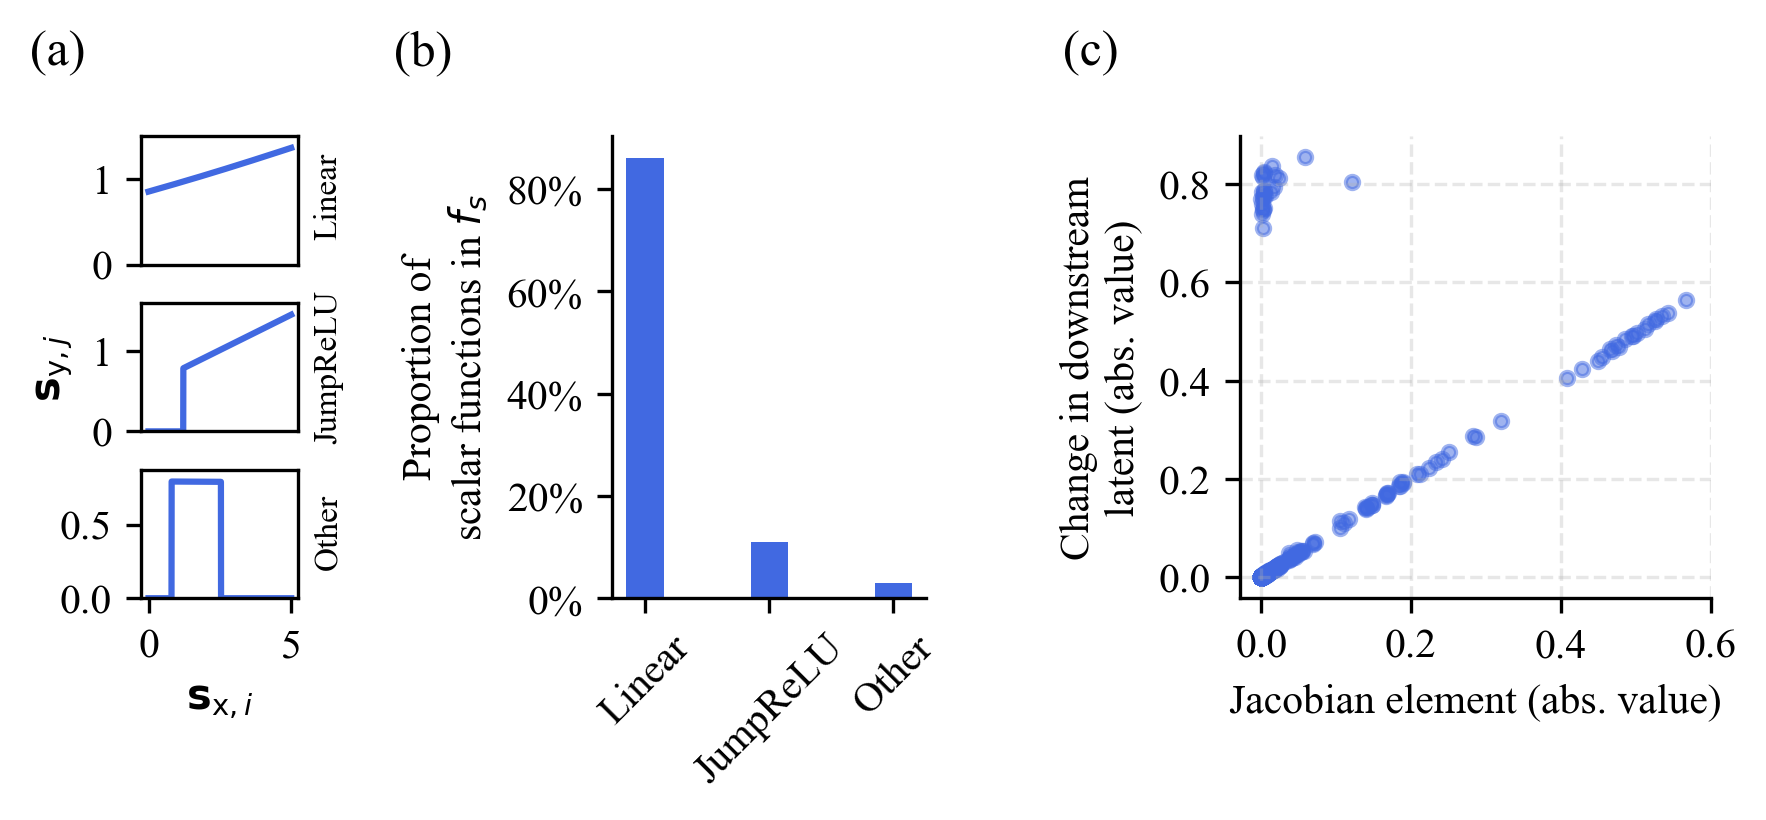

0.9749128818511963

In [173]:
fig = plt.figure(figsize=(6.75, 2), dpi=300)
gs = plt.GridSpec(1, 3, figure=fig, wspace=1, width_ratios=[1, 2, 3])

fig_color = "royalblue"

# Create sub-grid for the first panel
gs_left = gs[0].subgridspec(3, 1, hspace=0.3)

# Create all subplots
ax11 = fig.add_subplot(gs_left[0])  # Top subplot in first panel
ax12 = fig.add_subplot(gs_left[1])  # Middle subplot in first panel
ax13 = fig.add_subplot(gs_left[2])  # Bottom subplot in first panel
ax2 = fig.add_subplot(gs[1])       # Middle panel
ax3 = fig.add_subplot(gs[2])       # Right panel

ax11.plot(func_xs, linear_ys, color=fig_color)
ax11.set_xticks([])
ax11.set_ylim(0, max(linear_ys) * 1.1)
plt.figtext(0.21, 0.72, 'Linear', rotation=90, fontsize=8)
ax12.plot(func_xs, jumprelu_ys, color=fig_color)
ax12.set_xticks([])
ax12.set_ylim(0, max(jumprelu_ys) * 1.1)
ax12.set_ylabel('$\\mathbf{s}_{\\text{y},j}$')
plt.figtext(0.21, 0.38, 'JumpReLU', rotation=90, fontsize=8)
ax13.plot(func_xs, other_ys, color=fig_color)
ax13.set_ylim(0, max(other_ys) * 1.1)
ax13.set_xlabel('$\\mathbf{s}_{\\text{x},i}$')
plt.figtext(0.21, 0.17, 'Other', rotation=90, fontsize=8)


bar_width = 0.3
bar_positions = np.arange(3)
ax2.bar(bar_positions, [0.86, 0.11, 0.03], bar_width, color=fig_color)
ax2.set_xticks(bar_positions, ['Linear', 'JumpReLU', 'Other'], rotation=45)
ax2.set_ylabel('Proportion of\nscalar functions in $f_s$')
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax2.spines['right'].set_visible(False)


ax3.scatter(
    abl_sample_small[:, 0].cpu().numpy(),
    abl_sample_small[:, 1].cpu().numpy(),
    color=fig_color,
    alpha=0.5,  # Add some transparency
    s=10,  # Reduce marker size for paper
)
ax3.set_xlabel(f"Jacobian element{' (abs. value)' if take_abs else ''}")
ax3.set_ylabel(f"Change in downstream\nlatent{' (abs. value)' if take_abs else ''}", multialignment='center')
ax3.set_xticks([0, 0.2, 0.4, 0.6])
ax3.grid(True, linestyle='--', alpha=0.3)  # Subtle grid
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)



plt.figtext(0.07, 1, '(a)', fontsize=12)
plt.figtext(0.25, 1, '(b)', fontsize=12)
plt.figtext(0.58, 1, '(c)', fontsize=12)


plt.tight_layout()
plt.savefig('./charts/mostly_linear.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

is_on_line.float().mean().item()

TODO: bar plot for how many examples are on the line vs in the cluster

TODO: chart where each dot is a training run where you change the jac coeff; x axis is reconstruction quality, y axis is sparsity (and also simialr stuff for autointerp et al)

TODO: figure showing that the reconstruction quality (and autointerp) doesn't suffer

# Autointerp

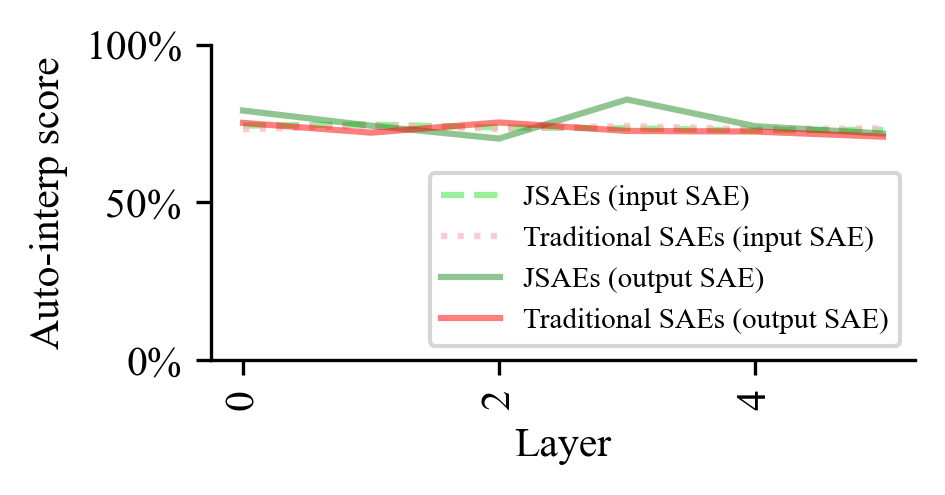

In [196]:
def parse_autointerp_data(path: str):
    with open(path) as f:
        raw_data = json.load(f)
    pre_mlp = []
    post_mlp = []
    for k, v in sorted(raw_data.items()):
        if "mlp" in k:
            post_mlp.append(v["mean"])
        else:
            pre_mlp.append(v["mean"])
    return pre_mlp, post_mlp

jsaes_pre_mlp, jsaes_post_mlp = parse_autointerp_data('../results/autointerp/jsaes/fuzz_results.json')
traditional_pre_mlp, traditional_post_mlp = parse_autointerp_data('../results/autointerp/traditional/fuzz_results.json')

plt.figure(figsize=(3.25, 1.75), dpi=300)

def format_layer(key):
    parts = key.split('.')
    return f"{parts[3]}_{"post-mlp" if parts[4]=="mlp" else "pre-mlp"}"

plt.plot(jsaes_pre_mlp, label='JSAEs (input SAE)', color='lightgreen', alpha=0.9, linestyle='--')
plt.plot(traditional_pre_mlp, label='Traditional SAEs (input SAE)', color='lightpink', alpha=0.7, linestyle=':')
plt.plot(jsaes_post_mlp, label='JSAEs (output SAE)', color='forestgreen', alpha=0.5)
plt.plot(traditional_post_mlp, label='Traditional SAEs (output SAE)', color='red', alpha=0.5)
plt.ylim(0, 1)


plt.legend(loc="lower right", fancybox=True, fontsize=7)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
plt.xlabel('Layer')
plt.ylabel('Auto-interp score')

# # Style adjustments
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/autointerp_pythia70m.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()